#  Load packages

In [2]:
# skip reinstalling packages we already have
using Pkg

pkgs = [
    "MLJ", "MLJBase", "MLJModels", "MLJEnsembles", "MLJLinearModels",
    "DecisionTree", "MLJDecisionTreeInterface", "NaiveBayes", 
    "MLJNaiveBayesInterface", "EvoTrees", "CategoricalArrays", "Random",
    "LIBSVM", "MLJLIBSVMInterface", "Plots", "MLJModelInterface",
    "CSV", "DataFrames", "UrlDownload", "XGBoost","MultivariateStats","PrettyTables"
]

# Filter out packages already installed
missing_pkgs = filter(pkg -> !(pkg in keys(Pkg.project().dependencies)), pkgs)

if !isempty(missing_pkgs)
    println("Installing missing packages: ", missing_pkgs)
    Pkg.add(missing_pkgs)
else
    println(" All required packages are already installed.")
end


 All required packages are already installed.


# Import packages

In [3]:
using CSV, DataFrames, Random
using Flux
using CategoricalArrays
using Plots
using Random
using Statistics
using DataFrames
using MLJ
using MLJBase
import Logging
using DataFrames
Logging.disable_logging(Logging.Info)

#Load your library of functions
include("utils.2.2.jl")
# Set a global random seed for reproducibility
Random.seed!(42)

# --- Accuracy function ---
#accuracy(pred::Vector{Int}, truth::Vector{Int}) = mean(pred .== truth)

TaskLocalRNG()

# Load Data

In [4]:
df = CSV.read("./data/updated_pollution_dataset.csv", DataFrame)
size(df)

(5000, 10)

In [5]:


df = CSV.read("./data/updated_pollution_dataset.csv", DataFrame)

# Some log
println("First 5 rows of df:")
show(df[1:5, :], allcols=true)


# Convert column 10 to categorical (in-place!)
df[!, 10] = categorical(df[!, 10])

# Get the column name as string
col10_name = string(names(df)[10])
println("Column 10 name: ", col10_name)

# Extract labels (categories) as strings
label_names = levels(df[!, 10])
println("Labels: ", label_names)

# Extract the integer codes of the categories
targets = Float32.(levelcode.(df[!, 10]))
inputs  = Matrix{Float32}(df[:, 1:9])



First 5 rows of df:
5×10 DataFrame
 Row │ Temperature  Humidity  PM2.5    PM10     NO2      SO2      CO       Proximity_to_Industrial_Areas  Population_Density  Air Quality 
     │ Float64      Float64   Float64  Float64  Float64  Float64  Float64  Float64                        Int64               String15    
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │        29.8      59.1      5.2     17.9     18.9      9.2     1.72                            6.3                 319  Moderate
   2 │        28.3      75.6      2.3     12.2     30.8      9.7     1.64                            6.0                 611  Moderate
   3 │        23.1      74.7     26.7     33.8     24.4     12.6     1.63                            5.2                 619  Moderate
   4 │        27.1      39.1      6.1      6.3     13.5      5.3     1.15                           11.1                 551  Good
   5 │      

5000×9 Matrix{Float32}:
 29.8  59.1    5.2   17.9  18.9   9.2  1.72   6.3  319.0
 28.3  75.6    2.3   12.2  30.8   9.7  1.64   6.0  611.0
 23.1  74.7   26.7   33.8  24.4  12.6  1.63   5.2  619.0
 27.1  39.1    6.1    6.3  13.5   5.3  1.15  11.1  551.0
 26.5  70.7    6.9   16.0  21.9   5.6  1.01  12.7  303.0
 39.4  96.6   14.6   35.5  42.9  17.9  1.82   3.1  674.0
 41.7  82.5    1.7   15.8  31.1  12.7  1.8    4.6  735.0
 31.0  59.6    5.0   16.8  24.2  13.6  1.38   6.3  443.0
 29.4  93.8   10.3   22.7  45.1  11.8  2.03   5.4  486.0
 33.2  80.5   11.1   24.4  32.0  15.3  1.69   4.9  535.0
  ⋮                               ⋮                
 31.8  80.2   22.4   34.1  29.7   4.9  1.22   9.4  580.0
 29.8  56.7    6.8   14.0  23.0   4.5  1.1   11.4  567.0
 34.9  77.7   32.3   47.1  17.4  11.5  1.63   8.8  541.0
 31.1  61.0   27.1   31.1  13.0   3.8  0.98  13.4  278.0
 40.6  74.1  116.0  126.7  45.5  25.7  2.11   2.8  765.0
 28.1  96.9    6.9   25.0  25.3  10.8  1.54   5.7  709.0
 25.9  78.2 

# Prepare data for ANN

In [6]:

N = size(df, 1)
trainIdx, valIdx, testIdx = holdOut(N, 0.1, 0.2)
#trainIdx, testIdx = holdOut(N, 0.3)
println("Train indices: ", length(trainIdx))
println("Validation indices: ", length(valIdx))
println("Test indices: ", length(testIdx))
println("df size: ", size(df))

trainingInputs  = inputs[trainIdx, :]
valInputs       = inputs[valIdx, :]
testInputs      = inputs[testIdx, :]

trainingTargets = targets[trainIdx]
valTargets      = targets[valIdx]
testTargets     = targets[testIdx]


println("\n\nFirst 5 targets:")
println(targets[1:5])

println("Training inputs (first 5 rows):")
for i in 1:5
    println(trainingInputs[i, :])
end


# Load PCA
PCA        = @load PCA pkg = MultivariateStats

Train indices: 3500
Validation indices: 500
Test indices: 1000
df size: (5000, 10)


First 5 targets:
Float32[3.0, 3.0, 3.0, 1.0, 1.0]
Training inputs (first 5 rows):
Float32[22.9, 50.0, 19.2, 23.4, 18.8, 6.0, 0.95, 12.2, 225.0]
Float32[36.8, 73.6, 36.0, 51.2, 24.5, 11.2, 1.53, 6.0, 630.0]
Float32[30.1, 49.0, 7.7, 14.5, 20.2, 7.6, 0.98, 11.0, 465.0]
Float32[46.8, 93.8, 11.8, 25.4, 33.8, 28.7, 3.27, 3.7, 589.0]
Float32[26.8, 55.7, 0.3, 6.2, 17.3, 5.6, 0.94, 11.4, 425.0]
import MLJMultivariateStatsInterface ✔


MLJMultivariateStatsInterface.PCA

# Normalize

In [7]:

println("\n\n=========== Normalizing Inputs ===========")

# Compute normalization parameters from TRAINING set only
normParams = calculateMinMaxNormalizationParameters(trainingInputs)

# Normalize training set IN PLACE
normalizeMinMax!(trainingInputs, normParams)

# Normalize validation set in place
normalizeMinMax!(valInputs, normParams)

# Normalize test set in place
#valInputs_normalized = normalizeMinMax(valInputs, normParams)
normalizeMinMax!(testInputs, normParams)


println("\nTraining inputs after normalization (first 5 rows):")
for i in 1:5
    println(trainingInputs[i, :])
end

println("\nValidation inputs after normalization (first 5 rows):")
for i in 1:5
    println(valInputs[i, :])
end

println("\nTest inputs after normalization (first 5 rows):")
for i in 1:5
    println(testInputs[i, :])
end


# Convert to float32 for Flux compatibility
trainingInputs = Float32.(trainingInputs)
valInputs = Float32.(valInputs)
testInputs = Float32.(testInputs)

# Clip values to [0,1] after normalization
valInputs .= clamp.(valInputs, 0f0, 1f0)
testInputs .= clamp.(testInputs, 0f0, 1f0)


# Values should only fall within [0,1]
@assert(all(minimum(trainingInputs, dims=1) .== 0))
@assert(all(maximum(trainingInputs, dims=1) .== 1))
@assert(all(minimum(valInputs, dims=1) .>= 0))
@assert(all(maximum(valInputs, dims=1) .<= 1))
@assert(all(minimum(testInputs, dims=1) .>= 0))
@assert(all(maximum(testInputs, dims=1) .<= 1))


println("Train inputs range per feature: ", (minimum(trainingInputs, dims=1), maximum(trainingInputs, dims=1)))
println("Validation inputs range per feature: ", (minimum(valInputs, dims=1), maximum(valInputs, dims=1)))
println("Test inputs range per feature: ", (minimum(testInputs, dims=1), maximum(testInputs, dims=1)))




=========== Normalizing Inputs ===========

Training inputs after normalization (first 5 rows):
Float32[0.21396396, 0.15108696, 0.06508475, 0.073804244, 0.1826241, 0.20612246, 0.09771987, 0.41630903, 0.046875]
Float32[0.527027, 0.40760866, 0.1220339, 0.16186254, 0.28368795, 0.3122449, 0.28664494, 0.1502146, 0.57421875]
Float32[0.37612614, 0.1402174, 0.026101694, 0.045612924, 0.20744681, 0.2387755, 0.107491866, 0.3648069, 0.359375]
Float32[0.7522523, 0.6271739, 0.04, 0.080139376, 0.44858155, 0.66938776, 0.85342014, 0.05150215, 0.5208333]
Float32[0.30180177, 0.21304348, 0.0010169492, 0.019322142, 0.15602835, 0.19795918, 0.094462544, 0.38197425, 0.30729166]

Validation inputs after normalization (first 5 rows):
Float32[0.3400901, 0.23043478, 0.062372882, 0.11023125, 0.429078, 0.36734694, 0.61563516, 0.10729614, 0.38671875]
Float32[0.46171173, 0.29782608, 0.18677966, 0.24928732, 0.5904255, 0.46938777, 0.43648207, 0.0472103, 0.3450521]
Float32[0.45495492, 0.17173915, 0.18745762, 0.1982895

# PCA

## Train ANN

import MLJMultivariateStatsInterface ✔

==== Starting ANN Experiments ====


===== Running ANN with topology = [6, 128, 256] =====

 Model: [6, 128, 256]   | PCA outdim = 6 
 Hyperparameters: Dict{String, Real}("epochs" => 200, "learningRate" => 0.01, "PCA_outdim" => 6)
 Accuracy                : 0.91
 Error Rate              : 0.09
 Sensitivity/Recall      : 0.91
 Specificity             : 0.9729
 PPV                     : 0.9101
 NPV                     : 0.9749
 F1 Score                : 0.9098

Confusion Matrix:
[382 1 0 0; 4 270 0 22; 0 0 78 25; 0 22 16 180]

┌───────────┬──────┬───────────┬──────────┬──────┐
│           │ Good │ Hazardous │ Moderate │ Poor │
├───────────┼──────┼───────────┼──────────┼──────┤
│      Good │  382 │         1 │        0 │    0 │
│ Hazardous │    4 │       270 │        0 │   22 │
│  Moderate │    0 │         0 │       78 │   25 │
│      Poor │    0 │        22 │       16 │  180 │
└───────────┴──────┴───────────┴──────────┴──────┘

===== Running ANN wi

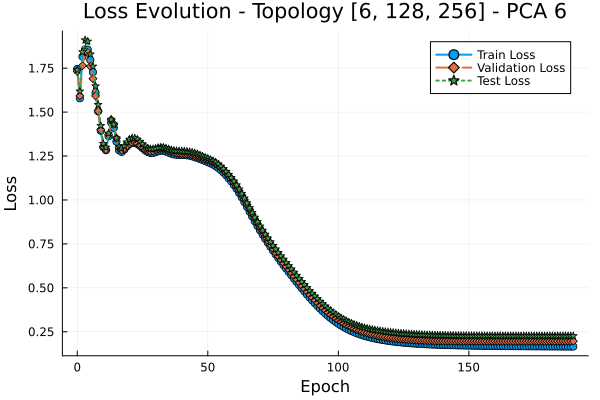

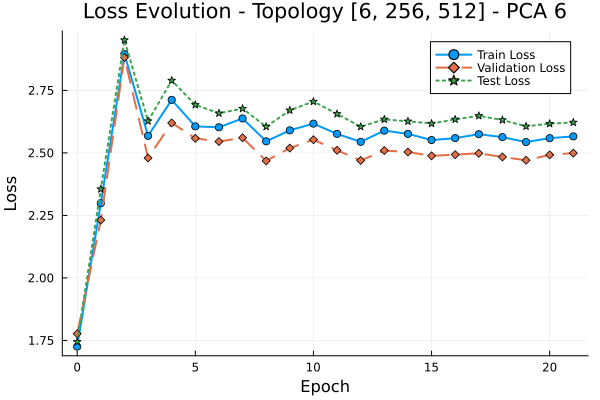

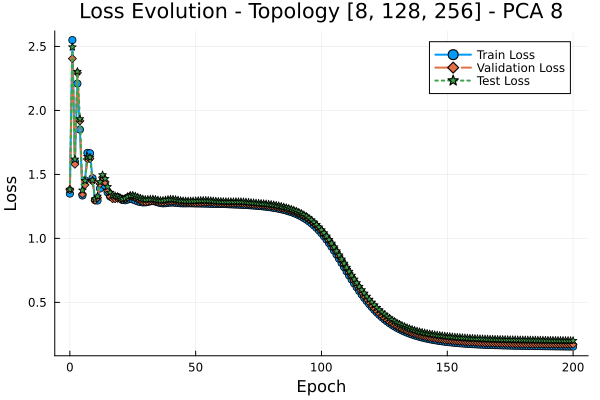

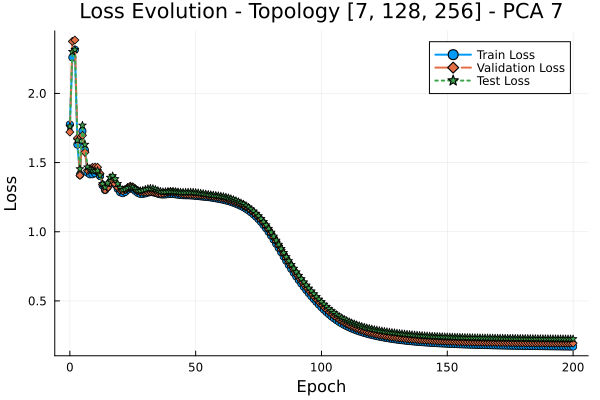

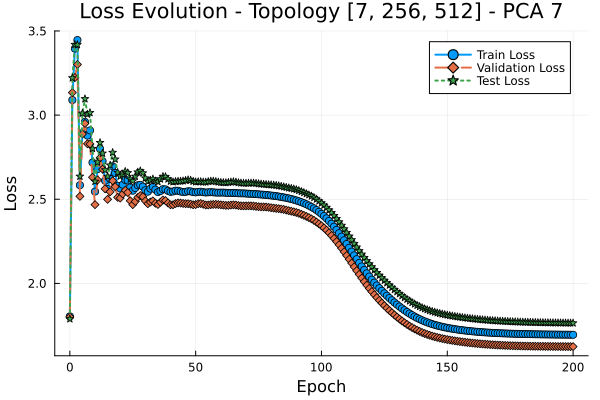

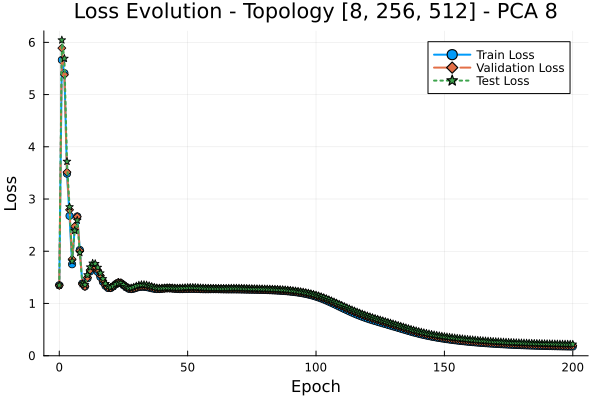

In [8]:
using Flux
using Statistics
using Plots
using MLJ
using MLJBase
using MLJModels
using DataFrames
using PrettyTables

# ---------------------- SAFE ACCURACY ----------------------
accuracy_score(pred::Vector{Int}, truth::Vector{Int}) = mean(pred .== truth)
accuracy = accuracy_score
const Losses = Flux

# ---------------------- PCA ----------------------
PCA = @load PCA pkg=MultivariateStats
dims = [6, 7, 8]

# ---------------------- BASE HIDDEN LAYERS ----------------------
base_hidden_layers = [
    [128, 256],
    [256, 512]
]

learningRate = 0.01
epochs = 200
results = Dict{String, Dict{Int, Tuple{Vector{Float32}, Vector{Float32}, Vector{Float32}}}}()

class_labels = unique(trainingTargets)
labels = string.(class_labels)

println("\n==== Starting ANN Experiments ====\n")

# ---------------------- MAIN LOOP ----------------------
for outdim in dims
    # --- PCA transformation ---
    pca_model = PCA(maxoutdim = outdim)
    pca_mach = machine(pca_model, MLJ.table(trainingInputs))
    MLJ.fit!(pca_mach)

    pca_train = MLJBase.matrix(MLJ.transform(pca_mach, MLJ.table(trainingInputs)))
    pca_val   = MLJBase.matrix(MLJ.transform(pca_mach, MLJ.table(valInputs)))
    pca_test  = MLJBase.matrix(MLJ.transform(pca_mach, MLJ.table(testInputs)))

    # --- One-hot encode targets ---
    trainingTargetsOH = oneHotEncoding(trainingTargets, class_labels)
    valTargetsOH      = oneHotEncoding(valTargets, class_labels)
    testTargetsOH     = oneHotEncoding(testTargets, class_labels)

    # --- Create full hidden layers including PCA dim ---
    hidden_layers_list = [[outdim; hl...] for hl in base_hidden_layers]

    for topology in hidden_layers_list
        topo_key = string(topology)
        results[topo_key] = Dict{Int, Tuple{Vector{Float32}, Vector{Float32}, Vector{Float32}}}()

        println("\n===== Running ANN with topology = $topology =====")

        # --- Train ANN ---
        finalAnn, trainLoss, valLoss, testLoss = trainClassANN(
            topology,
            (pca_train, trainingTargetsOH),
            validationDataset = (pca_val, valTargetsOH),
            testDataset       = (pca_test, testTargetsOH),
            maxEpochs = epochs,
            learningRate = learningRate,
            showText = false
        )

        # --- Store losses ---
        results[topo_key][outdim] = (trainLoss, valLoss, testLoss)


        testOutputs = finalAnn(pca_test')
        testPredictions = classifyOutputs(testOutputs')  # boolean matrix

        # --- Metrics ---
        cm_metrics = confusionMatrix(testPredictions, testTargetsOH)
        cm = cm_metrics[end]

        printPCAANNResult(
            topology,
            Dict("learningRate" => learningRate, "epochs" => epochs, "PCA_outdim" => outdim),
            cm_metrics,
            outdim,
            label_names
        )
    end
end

println("\n==== Finished All Experiments ====\n")

# ---------------------- PLOT LOSSES ----------------------
for (topology, dims_dict) in results
    for (outdim, (trainLoss, valLoss, testLoss)) in dims_dict
        epoch_vec = 0:length(trainLoss)-1
        p = plot(epoch_vec, trainLoss, label="Train Loss", lw=2, marker=:circle)

        if !isempty(valLoss)
            plot!(p, epoch_vec, valLoss, label="Validation Loss",
                  lw=2, linestyle=:dash, marker=:diamond)
        end

        if !isempty(testLoss)
            plot!(p, epoch_vec, testLoss, label="Test Loss",
                  lw=2, linestyle=:dot, marker=:star)
        end

        xlabel!("Epoch")
        ylabel!("Loss")
        title!("Loss Evolution - Topology $(topology) - PCA $outdim")
        plot!(legend=:topright)
        display(p)
    end
end


# SVM/KNN/DT

## Prepare data for SVM/KNN/DT

In [9]:

trainIdx, testIdx = holdOut(N, 0.3)
println("Train indices: ", length(trainIdx))
println("Test indices: ", length(testIdx))
println("df size: ", size(df))

trainingInputs  = inputs[trainIdx, :]
testInputs      = inputs[testIdx, :]

trainingTargets = targets[trainIdx]
testTargets     = targets[testIdx]

println("\n\nFirst 5 targets:")
println(targets[1:5])

println("Training inputs (first 5 rows):")
for i in 1:5
    println(trainingInputs[i, :])
end



println("\n\n=========== Normalizing Inputs ===========")

# Compute normalization parameters from TRAINING set only
normParams = calculateMinMaxNormalizationParameters(trainingInputs)

# Normalize training set IN PLACE
normalizeMinMax!(trainingInputs, normParams)

# Normalize test set in place
#valInputs_normalized = normalizeMinMax(valInputs, normParams)
normalizeMinMax!(testInputs, normParams)


println("\nTraining inputs after normalization (first 5 rows):")
for i in 1:5
    println(trainingInputs[i, :])
end

println("\nTest inputs after normalization (first 5 rows):")
for i in 1:5
    println(testInputs[i, :])
end

# Convert to float32 for Flux compatibility
trainingInputs = Float32.(trainingInputs)
testInputs = Float32.(testInputs)

# Clip values to [0,1] after normalization
testInputs .= clamp.(testInputs, 0f0, 1f0)
testInputs .= clamp.(testInputs, 0f0, 1f0)

# Convert directly to DataFrames for MLJ
train_df = DataFrame(trainingInputs, :auto)
test_df  = DataFrame(testInputs, :auto)

# Values should only fall within [0,1]
@assert(all(minimum(trainingInputs, dims=1) .== 0))
@assert(all(maximum(trainingInputs, dims=1) .== 1))
@assert(all(minimum(testInputs, dims=1) .>= 0))
@assert(all(maximum(testInputs, dims=1) .<= 1))


println("Train inputs range per feature: ", (minimum(trainingInputs, dims=1), maximum(trainingInputs, dims=1)))
println("Test inputs range per feature: ", (minimum(testInputs, dims=1), maximum(testInputs, dims=1)))


Train indices: 3500
Test indices: 1500
df size: (5000, 10)


First 5 targets:
Float32[3.0, 3.0, 3.0, 1.0, 1.0]
Training inputs (first 5 rows):
Float32[31.5, 85.2, 11.3, 21.9, 26.6, 9.1, 1.2, 5.2, 676.0]
Float32[23.7, 46.8, 1.2, 6.6, 23.4, 3.1, 1.07, 10.4, 531.0]
Float32[34.9, 81.1, 38.2, 52.3, 20.9, 7.5, 1.68, 5.5, 672.0]
Float32[45.0, 82.6, 17.4, 27.2, 46.3, 10.1, 2.82, 3.7, 592.0]
Float32[35.0, 85.2, 7.5, 18.9, 51.5, 23.9, 3.03, 6.5, 628.0]


=========== Normalizing Inputs ===========

Training inputs after normalization (first 5 rows):
Float32[0.38687786, 0.53420186, 0.038305085, 0.06993671, 0.33391306, 0.31546393, 0.17915311, 0.115879826, 0.64980024]
Float32[0.21040729, 0.11726383, 0.0040677967, 0.021518987, 0.27826086, 0.19175257, 0.13680783, 0.33905578, 0.45672438]
Float32[0.46380097, 0.4896851, 0.12949152, 0.16613925, 0.2347826, 0.28247422, 0.33550486, 0.12875538, 0.644474]
Float32[0.6923078, 0.5059717, 0.05898305, 0.086708866, 0.6765217, 0.33608246, 0.7068404, 0.05150215, 0.537

# SVM

In [10]:
using MLJ, LIBSVM, CategoricalArrays, MLJBase, DataFrames

# Init PCA
PCA        = @load PCA pkg = MultivariateStats
dims = [6,7,8]

# --- Default hyperparameters ---
default_svm = Dict(
    "gamma"  => 1.0,
    "degree" => Int32(3),
    "coef0"  => 0.0
)

# --- Hyperparameter search space ---
svm_search_space = [
    Dict("kernel"=>"linear",  "C"=>0.1),
    Dict("kernel"=>"linear",  "C"=>1.0),
    Dict("kernel"=>"linear",  "C"=>10.0),
    Dict("kernel"=>"rbf",     "C"=>1.0, "gamma"=>2.0),
    Dict("kernel"=>"rbf",     "C"=>10.0,"gamma"=>0.5),
    Dict("kernel"=>"sigmoid", "C"=>1.0, "gamma"=>1.0),
    Dict("kernel"=>"poly",    "C"=>1.0, "degree"=>3, "gamma"=>1.0),
    Dict("kernel"=>"poly",    "C"=>5.0, "degree"=>4, "gamma"=>0.5),
]

# --- Convert targets ---
train_y_cat = categorical(vec(trainingTargets))
test_y_cat  = categorical(vec(testTargets))

# --- Container for results ---
svm_results = []

# --- Wrap PCA / raw data as DataFrames ---
# Assume train_df and test_df are already prepared DataFrames of features
# e.g., train_df = DataFrame(pca_train, :auto), test_df = DataFrame(pca_test, :auto)

for hp in svm_search_space
    println("\n=== SVM experiment: kernel=$(hp["kernel"]) C=$(hp["C"]) ===")

    # Map string kernels to LIBSVM.Kernel enums
    kernel_enum = hp["kernel"] == "linear"  ? LIBSVM.Kernel.Linear  :
                  hp["kernel"] == "rbf"     ? LIBSVM.Kernel.RadialBasis :
                  hp["kernel"] == "sigmoid" ? LIBSVM.Kernel.Sigmoid :
                  hp["kernel"] == "poly"    ? LIBSVM.Kernel.Polynomial :
                  error("Unsupported kernel: $(hp["kernel"])")

    cost   = Float64(hp["C"])
    gamma  = Float64(get(hp, "gamma", 1.0))
    degree = Int32(get(hp, "degree", 3))
    coef0  = Float64(get(hp, "coef0", 0.0))

    # Load MLJ SVM model
    SVM_model = @load SVC pkg=LIBSVM verbosity=0
    model = SVM_model(
        kernel = kernel_enum,
        cost   = cost,
        gamma  = gamma,
        degree = degree,
        coef0  = coef0
    )
    for outdim in dims
        println("\n===== Running PCA with maxoutdim = $outdim =====")

        # ------ Fit PCA ------
        pca_model = PCA(maxoutdim = outdim)
        pca_mach = machine(pca_model, MLJ.table(trainingInputs))
        MLJ.fit!(pca_mach)

        # Transform data
        pca_train = MLJ.transform(pca_mach, MLJ.table(trainingInputs))
        pca_test  = MLJ.transform(pca_mach, MLJ.table(testInputs))

        # Convert to DataFrames
        pca_train_df = DataFrame(MLJBase.matrix(pca_train), :auto)
        pca_test_df  = DataFrame(MLJBase.matrix(pca_test), :auto)

        # Fit SVM on PCA data
        svm_mach = machine(model, pca_train_df, train_y_cat)
        MLJ.fit!(svm_mach)

        # Predict
        ŷ = MLJ.predict(svm_mach, pca_test_df)
        y_pred = CategoricalArray(ŷ)



        # --- Metrics ---
        # --- Compute metrics using your function ---
        accuracy, error_rate, recall, specificity, ppv, npv, f1, cm =
            confusionMatrix(y_pred, test_y_cat)

        #println("Accuracy = ", round(accuracy, digits=4))

        push!(svm_results, (
            model = :SVC,
            hyperparams = hp,
            metrics = (accuracy, error_rate, recall, specificity, ppv, npv, f1, cm),
            maxoutdim = outdim
        ))
    end


end

results = Dict(:SVC => svm_results)
println("\n===== Grid search finished =====")

for entry in results[:SVC]
    printPCAResult(entry.model, entry.hyperparams, entry.metrics,entry.maxoutdim,label_names)
    #printExperimentResult(:SVC, Dict("C"=>0.1, "kernel"=>"linear"), results, class_labels=labels)
end





import MLJMultivariateStatsInterface ✔

=== SVM experiment: kernel=linear C=0.1 ===

===== Running PCA with maxoutdim = 6 =====

===== Running PCA with maxoutdim = 7 =====

===== Running PCA with maxoutdim = 8 =====

=== SVM experiment: kernel=linear C=1.0 ===

===== Running PCA with maxoutdim = 6 =====

===== Running PCA with maxoutdim = 7 =====

===== Running PCA with maxoutdim = 8 =====

=== SVM experiment: kernel=linear C=10.0 ===

===== Running PCA with maxoutdim = 6 =====

===== Running PCA with maxoutdim = 7 =====

===== Running PCA with maxoutdim = 8 =====

=== SVM experiment: kernel=rbf C=1.0 ===

===== Running PCA with maxoutdim = 6 =====

===== Running PCA with maxoutdim = 7 =====

===== Running PCA with maxoutdim = 8 =====

=== SVM experiment: kernel=rbf C=10.0 ===

===== Running PCA with maxoutdim = 6 =====

===== Running PCA with maxoutdim = 7 =====

===== Running PCA with maxoutdim = 8 =====

=== SVM experiment: kernel=sigmoid C=1.0 ===

===== Running PCA with maxoutdim 

## DT

In [11]:
# ============================
# LOAD PCA
# ============================
# Init PCA
PCA        = @load PCA pkg = MultivariateStats
dims = [6,7,8]

############# 3. DECISION TREES (6 depths) #############
default_dt = Dict(
    "rng" => Random.MersenneTwister(1)
)

dt_search_space = [
    Dict("max_depth"=>2),
    Dict("max_depth"=>3),
    Dict("max_depth"=>4),
    Dict("max_depth"=>5),
    Dict("max_depth"=>6),
    Dict("max_depth"=>8)
]



# --- Convert targets ---

# --- Container for results ---
dt_results = []

# --- Wrap PCA / raw data as DataFrames ---
# Assume train_df and test_df are already prepared DataFrames of features

# ----------------------------
# DECISION TREE GRID SEARCH
# ----------------------------
for hp in dt_search_space
    println("\n=== Decision Tree experiment: max_depth=$(hp["max_depth"]) ===")
    
    # Merge default hyperparameters with current hp
    full_hp = merge(default_dt, hp)
    
    # Load DecisionTreeClassifier
    DT_model = @load DecisionTreeClassifier pkg=DecisionTree verbosity=0
    model = DT_model(
        max_depth = full_hp["max_depth"],
        rng       = full_hp["rng"]
    )
    
    # # --- Train machine ---
    # mach = machine(model, train_df, train_y_cat)
    # MLJ.fit!(mach)
    
    # # --- Predict ---
    # ŷ = MLJ.predict(mach, test_df)
    # y_pred = CategoricalArray(mode.(ŷ))  # convert MLJ probabilistic predictions to class labels

    for outdim in dims
        println("\n===== Running PCA with maxoutdim = $outdim =====")
        # ------ Fit PCA ------
        pca_model = PCA(maxoutdim = outdim)
        pca_mach = machine(pca_model, MLJ.table(trainingInputs))
        MLJ.fit!(pca_mach)

        # Transform data
        pca_train = MLJ.transform(pca_mach, MLJ.table(trainingInputs))
        pca_test  = MLJ.transform(pca_mach, MLJ.table(testInputs))

        # Convert to DataFrames
        pca_train_df = DataFrame(MLJBase.matrix(pca_train), :auto)
        pca_test_df  = DataFrame(MLJBase.matrix(pca_test), :auto)

        # Fit DT on PCA data
        dt_mach = machine(model, pca_train_df, train_y_cat)
        MLJ.fit!(dt_mach)

        # Predict
        ŷ = MLJ.predict(dt_mach, pca_test_df)
        y_pred = CategoricalArray(mode.(ŷ))  # convert MLJ probabilistic predictions to class labels



        # --- Compute metrics ---
        accuracy, error_rate, recall, specificity, ppv, npv, f1, cm =
            confusionMatrix(y_pred, test_y_cat)
        
        println("Accuracy = ", round(accuracy, digits=4))
    
        push!(dt_results, (
            model = :DecisionTree,
            hyperparams = hp,
            metrics = (accuracy, error_rate, recall, specificity, ppv, npv, f1, cm),
            maxoutdim = outdim))
    end
end

# Store results in dict
results[:DecisionTree] = dt_results
println("\n===== Grid search finished =====")

# ----------------------------
# Print all results
# ----------------------------
for entry in results[:DecisionTree]
    printPCAResult(entry.model, entry.hyperparams, entry.metrics, entry.maxoutdim,label_names)
end



import MLJMultivariateStatsInterface ✔

=== Decision Tree experiment: max_depth=2 ===

===== Running PCA with maxoutdim = 6 =====
Accuracy = 0.8287

===== Running PCA with maxoutdim = 7 =====
Accuracy = 0.8287

===== Running PCA with maxoutdim = 8 =====
Accuracy = 0.8287

=== Decision Tree experiment: max_depth=3 ===

===== Running PCA with maxoutdim = 6 =====
Accuracy = 0.9093

===== Running PCA with maxoutdim = 7 =====
Accuracy = 0.9093

===== Running PCA with maxoutdim = 8 =====
Accuracy = 0.9093

=== Decision Tree experiment: max_depth=4 ===

===== Running PCA with maxoutdim = 6 =====
Accuracy = 0.9213

===== Running PCA with maxoutdim = 7 =====
Accuracy = 0.9213

===== Running PCA with maxoutdim = 8 =====
Accuracy = 0.9213

=== Decision Tree experiment: max_depth=5 ===

===== Running PCA with maxoutdim = 6 =====
Accuracy = 0.9207

===== Running PCA with maxoutdim = 7 =====
Accuracy = 0.9213

===== Running PCA with maxoutdim = 8 =====
Accuracy = 0.9247

=== Decision Tree experiment

## KNN

In [12]:
# Init PCA
PCA        = @load PCA pkg = MultivariateStats
dims = [6,7]
############# 4. kNN (6 values) #############
knn_search_space = [
    Dict("K"=>1),
    Dict("K"=>3),
    Dict("K"=>5),
    Dict("K"=>7),
    Dict("K"=>9),
    Dict("K"=>11)
]

# --- Convert targets ---
train_y_cat = categorical(vec(trainingTargets))
test_y_cat  = categorical(vec(testTargets))

# --- Container for results ---
knn_results = []

# --- kNN hyperparameter search space ---
knn_search_space = [
    Dict("K"=>1),
    Dict("K"=>3),
    Dict("K"=>5),
    Dict("K"=>7),
    Dict("K"=>9),
    Dict("K"=>11)
]

# --- Loop over K values ---
KNN_model_type = @load KNNClassifier pkg=NearestNeighborModels verbosity=0

for hp in knn_search_space
    println("\n=== kNN experiment: K=$(hp["K"]) ===")
    
    K = Int(hp["K"])
    
    # Load MLJ KNN model
    model = KNN_model_type(K=K)
    for outdim in dims
        println("\n===== Running PCA with maxoutdim = $outdim =====")
        # ------ Fit PCA ------
        pca_model = PCA(maxoutdim = outdim)
        pca_mach = machine(pca_model, MLJ.table(trainingInputs))
        MLJ.fit!(pca_mach)

        # Transform data
        pca_train = MLJ.transform(pca_mach, MLJ.table(trainingInputs))
        pca_test  = MLJ.transform(pca_mach, MLJ.table(testInputs))

        # Convert to DataFrames
        pca_train_df = DataFrame(MLJBase.matrix(pca_train), :auto)
        pca_test_df  = DataFrame(MLJBase.matrix(pca_test), :auto)

        # Fit KNN on PCA data
        dt_mach = machine(model, pca_train_df, train_y_cat)
        MLJ.fit!(dt_mach)

        # Predict
        ŷ = MLJ.predict(dt_mach, pca_test_df)
        y_pred = CategoricalArray(mode.(ŷ))  # convert MLJ probabilistic predictions to class labels
        # # --- Train machine ---
        # mach = machine(model, train_df, train_y_cat)
        # MLJ.fit!(mach)
        
        # # --- Predict ---
        # ŷ = MLJ.predict(mach, test_df)              # probabilistic predictions
        # y_pred = CategoricalArray(mode.(ŷ))         # convert to class labels
        
        # --- Compute metrics ---
        accuracy, error_rate, recall, specificity, ppv, npv, f1, cm =
             confusionMatrix(y_pred, test_y_cat)
        
        println("Accuracy = ", round(accuracy, digits=4))
        
        # --- Save results ---
        push!(knn_results, (
             model = :kNN,
             hyperparams = hp,
             metrics = (accuracy, error_rate, recall, specificity, ppv, npv, f1, cm),
             maxoutdim = outdim
         ))
    end
        
end

# --- Store all results ---
results[:kNN] = knn_results

# --- Print results ---
for entry in results[:kNN]
    printPCAResult(entry.model, entry.hyperparams, entry.metrics,entry.maxoutdim, label_names)
end


import MLJMultivariateStatsInterface ✔

=== kNN experiment: K=1 ===

===== Running PCA with maxoutdim = 6 =====
Accuracy = 0.9073

===== Running PCA with maxoutdim = 7 =====
Accuracy = 0.9147

=== kNN experiment: K=3 ===

===== Running PCA with maxoutdim = 6 =====
Accuracy = 0.928

===== Running PCA with maxoutdim = 7 =====
Accuracy = 0.9307

=== kNN experiment: K=5 ===

===== Running PCA with maxoutdim = 6 =====
Accuracy = 0.9293

===== Running PCA with maxoutdim = 7 =====
Accuracy = 0.928

=== kNN experiment: K=7 ===

===== Running PCA with maxoutdim = 6 =====
Accuracy = 0.9293

===== Running PCA with maxoutdim = 7 =====
Accuracy = 0.932

=== kNN experiment: K=9 ===

===== Running PCA with maxoutdim = 6 =====
Accuracy = 0.928

===== Running PCA with maxoutdim = 7 =====
Accuracy = 0.9287

=== kNN experiment: K=11 ===

===== Running PCA with maxoutdim = 6 =====
Accuracy = 0.9253

===== Running PCA with maxoutdim = 7 =====
Accuracy = 0.9273

 Model: kNN outdim 6 
 Hyperparameters: Dict(